# Prepare the Data

In [1]:
import addutils.toc ; addutils.toc.js(ipy_notebook=True)

In [2]:
import scipy.io
import numpy as np
import pandas as pd
from sklearn import datasets
from addutils import css_notebook
css_notebook()

## 1 Introduction

Data in scikit-learn, with very few exceptions, is assumed to be stored as a
**two-dimensional array**, of size `[n_samples, n_features]`.

Most machine learning algorithms implemented in scikit-learn expect data to be stored in a
**two-dimensional array or matrix**.  The arrays can be
either ``numpy`` arrays, pandas ``DataFrame``, or in some cases ``scipy.sparse`` matrices.
The size of the array is expected to be `[n_samples, n_features]`

The number of features must be fixed in advance. However it can be very high dimensional
(e.g. millions of features) with most of them being zeros for a given sample. This is a case
where `scipy.sparse` matrices can be useful, in that they are
much more memory-efficient than numpy arrays.

## 2 Exploratory Data Analysis (EDA)

Although it is not required, in many cases it can be easier to manage the data pre-processing with **pandas**:

In [10]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [11]:
pd.options.display.notebook_repr_html = True
df = pd.DataFrame(d.data, columns=d.feature_names)
df['y'] = d.target
df.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),y
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0


In [12]:
pd.set_option('precision',3)
df[df.columns[:4]].describe().ix[[1,2,3,7]]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
mean,5.843,3.054,3.759,1.199
std,0.828,0.434,1.764,0.763
min,4.300,2.000,1.000,0.100
max,7.900,4.400,6.900,2.500


In [13]:
x_feat, y_feat = 2, 3 # Choose the features to plot (0-3)
fig = bk.figure(title=None)
colors = ['#006CD1', '#26D100', '#D10000']
color_series = [ colors[i] for i in df['y'] ]
fig.scatter(df[df.columns[x_feat]], df[df.columns[y_feat]], 
            line_color='black', fill_color=color_series,
            radius=0.1)
fig.xaxis.axis_label = df.columns[x_feat]
fig.yaxis.axis_label = df.columns[y_feat]

bk.show(fig)

Pandas contains some utility functions and plotting functions that can help in previewing the data. In this case we use a `scatter_matrix` pandas plot to plot the four features one versus the other:

**TODO -** Check if it's possible to add class colors to the following scatter matrix with the property `group_col`.

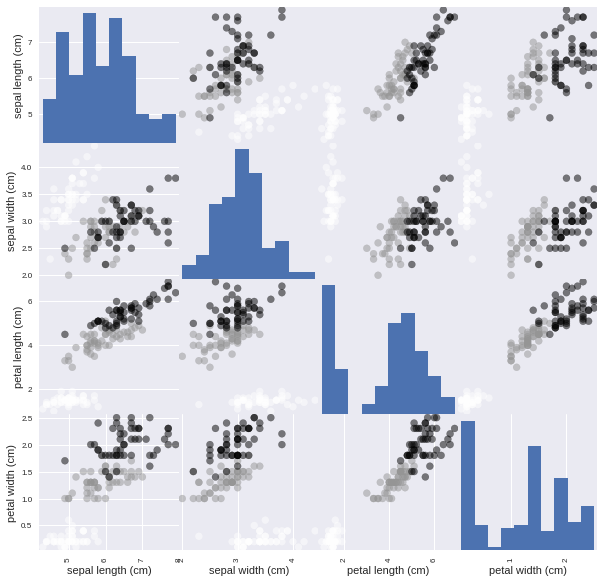

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

pd.tools.plotting.scatter_matrix(df[df.columns[:4]], figsize=(10, 10),
                                 c=df['y'], diagonal='hist', marker='o')
plt.show()

## 4 Preprocessing Data

### 4.1 Standardizing = Mean Removal + Variance Scaling:

Standardization of datasets is a common requirement for many machine learning estimators: they might behave badly if the individual feature do not more or less look like *standard normally distributed data*: Gaussian with zero mean and unit variance. In practice we often ignore the shape of the distribution and just transform the data to center and scale by dividing by the standard deviation.

*If the input variables are combined via a distance function* (such as Euclidean distance), standardizing inputs can be crucial. If
one input has a range of 0 to 1, while another input has a range of 0 to 1,000,000, then the contribution of the first input to the distance will be swamped by the second input.

It is sometimes not enough to center and scale the features independently, since a downstream model can further make some assumption on the linear independence of the features. To address this issue you can use `sklearn.decomposition.PCA` or `sklearn.decomposition.RandomizedPCA` with `whiten=True` to further remove the linear correlation across features.

`scale` and `StandardScaler` work out-of-the-box with 1d arrays.

`preprocessing.scale` scales each column of the features matric to **mean=0 and std=1**. This is also called **"STANDARDIZATION"**.

In [18]:
from sklearn import preprocessing
X = np.array([[ 10.,  1., 0.],
              [ 20.,  0., 2.]])

In [19]:
X_sc_1 = preprocessing.scale(X)
print(X)
print('\nScaled Values: ')
print(X_sc_1)

[[ 10.   1.   0.]
 [ 20.   0.   2.]]

Scaled Values: 
[[-1.  1. -1.]
 [ 1. -1.  1.]]


`preprocessing.StandardScaler` keeps the values of `.mean_` and `.std_` to allow lately `transform` and `inverse_transform` **mean** and **std** scaling can be controlled independently:

In [20]:
scaler = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(X)
X_sc_2 = scaler.transform(X)
print('\nScaled Values: ')
print(X_sc_2)
print('\nStandard Scaler Mean: ', scaler.mean_)
print('Standard Scaler Std:  ', scaler.std_)
print('\nInverse Transform: ')
print(scaler.inverse_transform(X_sc_2))


Scaled Values: 
[[-1.  1. -1.]
 [ 1. -1.  1.]]

Standard Scaler Mean:  [ 15.    0.5   1. ]
Standard Scaler Std:   [ 5.   0.5  1. ]

Inverse Transform: 
[[ 10.   1.   0.]
 [ 20.   0.   2.]]


### 4.2 Using the preprocessing.StandardScaler with pandas:

In [21]:
X = np.array([[ 10.,  1., 0.],
              [ 20.,  0., 2.]])
df = pd.DataFrame(X)
df

,0,1,2
0,10.0,1.0,0.0
1,20.0,0.0,2.0


In [22]:
df.describe().ix[[1,2]]

,0,1,2
mean,15.000,0.500,1.000
std,7.071,0.707,1.414


In [23]:
scaler = preprocessing.StandardScaler(copy=False, with_mean=True, with_std=True).fit(df)
print('\nStandard Scaler Mean: ', scaler.mean_)
print('Standard Scaler Std:  ', scaler.std_)
df_sc_2 = pd.DataFrame(scaler.transform(df))
df_sc_2


Standard Scaler Mean:  [ 15.    0.5   1. ]
Standard Scaler Std:   [ 5.   0.5  1. ]


,0,1,2
0,-1.0,1.0,-1.0
1,1.0,-1.0,1.0


In [24]:
df_inv =  pd.DataFrame(scaler.inverse_transform(df_sc_2))
df_inv

,0,1,2
0,10.0,1.0,0.0
1,20.0,0.0,2.0


### 4.3 Normalizing = Dividing by a Norm of the Vector:

`preprocessing.normalize` sets thenorm of the vector =1.

By default `(axis=1)`, so if it's necessary to normalize the columns  and not the rows, `axis` must be set to 0.

In [25]:
X = np.array([[ 10.,  1., 0.],
              [ 20.,  0., 2.],
              [ 20.,  0., 0.]])
X_nrm = preprocessing.normalize(X, norm='l2', axis=0)
print('\nNormalized Values: ')
print(X_nrm)


Normalized Values: 
[[ 0.33333333  1.          0.        ]
 [ 0.66666667  0.          1.        ]
 [ 0.66666667  0.          0.        ]]


## 5 Features Extraction

Features extraction (module `sklearn.feature_extraction`) consists in transforming arbitrary data, such as text or images, into numerical features usable for machine learning.

### 5.1 Derived Features:

Are obtained by pre-processing the data to generate features that are somehow more informative.  Derived
features may be linear or nonlinear combinations of features (such as in Polynomial regression), or may be some more sophisticated transform of the features.  The latter is often used in image processing.

For example, [scikit-image](http://scikit-image.org/) provides a variety of feature
extractors designed for image data: see the ``skimage.feature`` submodule.

### 5.2 DictVectorizer uses "one-hot" encoder for categorical features:

`feature_extraction.DictVectorizer` implements what is called one-of-K or “one-hot” coding for categorical (aka nominal, discrete) features.

In the following code the method `vec.fit_transform(temp)` returns a sparse matrix that is tranformed to dense by `.toarray()`.

In [26]:
from sklearn import feature_extraction
t = [{'city': 'Dubai', 'temperature': 33.},
     {'city': 'London', 'temperature': 12.},
     {'city': 'San Fransisco', 'temperature': 18.},]

vec = feature_extraction.DictVectorizer()
t_vec = vec.fit_transform(t)
df = pd.DataFrame(t_vec.toarray(), columns=vec.get_feature_names())
df

,city=Dubai,city=London,city=San Fransisco,temperature
0,1.0,0.0,0.0,33.0
1,0.0,1.0,0.0,12.0
2,0.0,0.0,1.0,18.0


### 5.3 The Bag of Words representation:

We call **vectorization** the general process of turning a collection of text documents into numerical feature vectors. *This specific strategy (tokenization, counting and normalization) is called the Bag of Words or “Bag of n-grams” representation*. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

`CountVectorizer` implements both tokenization and occurrence counting in a single class:

In [27]:
feature_extraction.text.CountVectorizer?

In [28]:
corpus = ['This is the x-first document.', 'This is the second second document.',
          'And the third third third one.', 'Is this the first document?']
vec = feature_extraction.text.CountVectorizer()
X = vec.fit_transform(corpus)
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
df

,and,document,first,is,one,second,the,third,this
0,0,1,1,1,0,0,1,0,1
1,0,1,0,1,0,2,1,0,1
2,1,0,0,0,1,0,1,3,0
3,0,1,1,1,0,0,1,0,1


The default configuration tokenizes the string by extracting words of at least 2 letters. The specific function that does this step can be requested explicitly:

In [29]:
analyzer = vec.build_analyzer()
analyzer("This is the x-first document.")

['this', 'is', 'the', 'first', 'document']

 Words that were not seen in the training corpus will be completely ignored in future calls to the transform method:

In [30]:
print(vec.transform(['Something completely new.']).toarray())

[[0 0 0 0 0 0 0 0 0]]


Note that in the previous corpus we lose the information that the last document is an interrogative form because each word is encoded individually. To preserve the local ordering information we can extract 2-grams of words in addition to the 1-grams (the word themselves):

In [31]:
vec_bi = feature_extraction.text.CountVectorizer(min_df=1, ngram_range=(1, 2))
X_bi = vec_bi.fit_transform(corpus)
pd.set_option('display.max_columns', None)
df_bi = pd.DataFrame(X_bi.toarray(), columns=vec_bi.get_feature_names())
df_bi

,and,and the,document,first,first document,is,is the,is this,one,second,second document,second second,the,the first,the second,the third,third,third one,third third,this,this is,this the
0,0,0,1,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0
1,0,0,1,0,0,1,1,0,0,2,1,1,1,0,1,0,0,0,0,1,1,0
2,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,3,1,2,0,0,0
3,0,0,1,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,1


In a large text corpus, some words will be very present (e.g. “the”, “a”, “is” in English) hence carrying very little meaningful information. For this reason  it is very common to use the `tf–idf` (term-frequency / inverse document-frequency) transform: each row is normalized to have unit euclidean norm. The weights of each feature computed by the fit method call are stored in a model attribute:

In [32]:
corpus = [ 'aa aa cc dd', 'aa cc',
           'aa bb cc ff', "aa aa"]
tfidf = feature_extraction.text.TfidfVectorizer()
X = tfidf.fit_transform(corpus)
print(X.toarray())

[[ 0.66052121  0.          0.40395613  0.63287533  0.        ]
 [ 0.63295194  0.          0.77419109  0.          0.        ]
 [ 0.31878155  0.61087812  0.38991559  0.          0.61087812]
 [ 1.          0.          0.          0.          0.        ]]


Check scikit-learn documentation for additional information on feature extraction.

---

Visit [www.add-for.com](<http://www.add-for.com/IT>) for more tutorials and updates.

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.